**PROBLEM 4**: SPORTS OR POLITICS

You have to design a classifier that reads a text document and classify it as Sport or Politics
using any of your favorite machine learning techniques. For feature representation you can
use: n-grams, TF-IDF, Bag of Words. You should compare atleast three ML Techniques for
this task.



In [ ]:
!pip install kagglehub


**STEP 1** :the dataset

In [ ]:
import kagglehub
import os
import pandas as pd

# Download dataset
path = kagglehub.dataset_download("yufengdev/bbc-fulltext-and-category")

# Find CSV file
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)

df = pd.read_csv(csv_path)

df.head()


Using Colab cache for faster access to the 'bbc-fulltext-and-category' dataset.


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
df = df[df['category'].isin(['sport', 'politics'])]

print(df['category'].value_counts())


category
sport       511
politics    417
Name: count, dtype: int64


**STEP 2** — Preprocessing

In [ ]:
import re

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(preprocess)

df.head()


,category,text,clean_text
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...
5,politics,howard hits back at mongrel jibe michael howar...,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...,henman hopes ended in dubai third seed tim hen...


**STEP 3** — Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'],
    df['category'],
    test_size=0.2,
    random_state=42
)


**STEP 4** — Create 3 Feature Representations

We will create:

Bag of Words

TF-IDF

TF-IDF with n-grams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Convert sparse matrix → numpy array
X_train = X_train.toarray()
X_test = X_test.toarray()

import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)


**STEP 5** — Define 3 ML Models

We will use:

Naive Bayes

Logistic Regression

SVM

# NAIVE BAYES

In [ ]:
class MyNaiveBayes:

    def fit(self, X, y):

        self.classes = np.unique(y)
        self.n_features = X.shape[1]

        self.class_log_prior = {}
        self.feature_log_prob = {}

        for c in self.classes:

            X_c = X[y == c]

            # Prior probability
            self.class_log_prior[c] = np.log(X_c.shape[0] / X.shape[0])

            # Word likelihood (Laplace smoothing)
            word_counts = X_c.sum(axis=0) + 1
            total_words = word_counts.sum()

            self.feature_log_prob[c] = np.log(word_counts / total_words)


    def predict(self, X):

        predictions = []

        for x in X:
            scores = {}

            for c in self.classes:

                score = self.class_log_prior[c]
                score += np.sum(x * self.feature_log_prob[c])

                scores[c] = score

            predictions.append(max(scores, key=scores.get))

        return np.array(predictions)


**STEP 6** — Create Evaluation Function

In [ ]:
nb_model = MyNaiveBayes()

nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

accuracy = np.mean(y_pred == y_test)

print("Naive Bayes Accuracy:", accuracy)


Custom Naive Bayes Accuracy: 1.0


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)


[[91  0]
 [ 0 95]]


# LOGISTIC REGRESSION

In [ ]:
# Convert labels to binary
y_train_lr = np.where(y_train == "sport", 1, 0)
y_test_lr = np.where(y_test == "sport", 1, 0)


Add bias column (column of 1s)

In [ ]:
# Add bias column (column of 1s)
X_train_lr = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_lr = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


Define Sigmoid Function

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


Implement Logistic Regression Class

In [ ]:
class MyLogisticRegression:

    def __init__(self, learning_rate=0.01, epochs=100):
        self.lr = learning_rate
        self.epochs = epochs


    def fit(self, X, y):

        self.weights = np.zeros(X.shape[1])

        for _ in range(self.epochs):

            z = np.dot(X, self.weights)
            predictions = sigmoid(z)

            # Gradient calculation
            gradient = np.dot(X.T, (predictions - y)) / y.size

            # Update weights
            self.weights -= self.lr * gradient


    def predict(self, X):

        z = np.dot(X, self.weights)
        predictions = sigmoid(z)

        return (predictions >= 0.5).astype(int)


Train Model

In [ ]:
lr_model = MyLogisticRegression(learning_rate=0.1, epochs=200)

lr_model.fit(X_train_lr, y_train_lr)


Evaluate

In [ ]:
y_pred_lr = lr_model.predict(X_test_lr)

accuracy_lr = np.mean(y_pred_lr == y_test_lr)

print("Custom Logistic Regression Accuracy:", accuracy_lr)


Custom Logistic Regression Accuracy: 1.0


# SVM


STEP 1 — Convert Labels to -1 and +1

In [ ]:
y_train_svm = np.where(y_train == "sport", 1, -1)
y_test_svm = np.where(y_test == "sport", 1, -1)


STEP 2 — Add Bias Column

In [ ]:
X_train_svm = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_svm = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


STEP 3 — Implement SVM Class

In [ ]:
class MyLinearSVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.01, epochs=200):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs


    def fit(self, X, y):

        self.weights = np.zeros(X.shape[1])

        for _ in range(self.epochs):

            for idx, x_i in enumerate(X):

                condition = y[idx] * np.dot(x_i, self.weights)

                if condition >= 1:
                    gradient = self.lambda_param * self.weights
                else:
                    gradient = self.lambda_param * self.weights - y[idx] * x_i

                self.weights -= self.lr * gradient


    def predict(self, X):

        linear_output = np.dot(X, self.weights)
        return np.sign(linear_output)


STEP 4 — Train SVM

In [ ]:
svm_model = MyLinearSVM(learning_rate=0.001, lambda_param=0.01, epochs=200)

svm_model.fit(X_train_svm, y_train_svm)


STEP 5 — Evaluate

In [ ]:
y_pred_svm = svm_model.predict(X_test_svm)

accuracy_svm = np.mean(y_pred_svm == y_test_svm)

print("Linear SVM Accuracy:", accuracy_svm)


Linear SVM Accuracy: 1.0


Create TF-IDF Features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()


Add Bias Term (for LR & SVM)

In [ ]:
X_train_tfidf_bias = np.hstack([np.ones((X_train_tfidf.shape[0], 1)), X_train_tfidf])
X_test_tfidf_bias = np.hstack([np.ones((X_test_tfidf.shape[0], 1)), X_test_tfidf])


Train All 3 Models on TF-IDF

In [ ]:
#Naive Bayes
nb_tfidf = MyNaiveBayes()
nb_tfidf.fit(X_train_tfidf, y_train)

y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
acc_nb_tfidf = np.mean(y_pred_nb_tfidf == y_test)

print("Naive Bayes (TF-IDF) Accuracy:", acc_nb_tfidf)


Naive Bayes (TF-IDF) Accuracy: 1.0


In [ ]:
#Logistic Regression
lr_tfidf = MyLogisticRegression(learning_rate=0.1, epochs=200)
lr_tfidf.fit(X_train_tfidf_bias, y_train_lr)

y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf_bias)
acc_lr_tfidf = np.mean(y_pred_lr_tfidf == y_test_lr)

print("Logistic Regression (TF-IDF) Accuracy:", acc_lr_tfidf)

Logistic Regression (TF-IDF) Accuracy: 0.6612903225806451


In [ ]:
#SVM
svm_tfidf = MyLinearSVM(learning_rate=0.001, lambda_param=0.01, epochs=200)
svm_tfidf.fit(X_train_tfidf_bias, y_train_svm)

y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf_bias)
acc_svm_tfidf = np.mean(y_pred_svm_tfidf == y_test_svm)

print("SVM (TF-IDF) Accuracy:", acc_svm_tfidf)

SVM (TF-IDF) Accuracy: 0.9838709677419355


In [ ]:
#Now Add n-grams

ngram_range=(1,2)

In [ ]:
tfidf_ngram_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2)
)

X_train_ng = tfidf_ngram_vectorizer.fit_transform(X_train_text)
X_test_ng = tfidf_ngram_vectorizer.transform(X_test_text)

X_train_ng = X_train_ng.toarray()
X_test_ng = X_test_ng.toarray()

X_train_ng_bias = np.hstack([np.ones((X_train_ng.shape[0], 1)), X_train_ng])
X_test_ng_bias = np.hstack([np.ones((X_test_ng.shape[0], 1)), X_test_ng])


Create Final Comparison Table

In [ ]:
import pandas as pd
import numpy as np

# Train Naive Bayes with TF-IDF + n-grams
nb_ng = MyNaiveBayes()
nb_ng.fit(X_train_ng, y_train)
y_pred_nb_ng = nb_ng.predict(X_test_ng)
acc_nb_ng = np.mean(y_pred_nb_ng == y_test)

# Train Logistic Regression with TF-IDF + n-grams
lr_ng = MyLogisticRegression(learning_rate=0.1, epochs=200)
lr_ng.fit(X_train_ng_bias, y_train_lr)
y_pred_lr_ng = lr_ng.predict(X_test_ng_bias)
acc_lr_ng = np.mean(y_pred_lr_ng == y_test_lr)

# Train SVM with TF-IDF + n-grams
svm_ng = MyLinearSVM(learning_rate=0.001, lambda_param=0.01, epochs=200)
svm_ng.fit(X_train_ng_bias, y_train_svm)
y_pred_svm_ng = svm_ng.predict(X_test_ng_bias)
acc_svm_ng = np.mean(y_pred_svm_ng == y_test_svm)

results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "SVM"],
    "BoW Accuracy": [accuracy, accuracy_lr, accuracy_svm],
    "TF-IDF Accuracy": [acc_nb_tfidf, acc_lr_tfidf, acc_svm_tfidf],
    "TF-IDF + ngram Accuracy": [
        acc_nb_ng, acc_lr_ng, acc_svm_ng
    ]
})

results

,Model,BoW Accuracy,TF-IDF Accuracy,TF-IDF + ngram Accuracy
0,Naive Bayes,1.0,1.000000,1.000000
1,Logistic Regression,1.0,0.661290,0.521505
2,SVM,1.0,0.983871,0.935484


In [ ]:
#Store All Accuracies Properly


results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "SVM"],
    "BoW": [accuracy, accuracy_lr, accuracy_svm],
    "TF-IDF": [acc_nb_tfidf, acc_lr_tfidf, acc_svm_tfidf],
    "TF-IDF + ngram": [acc_nb_ng, acc_lr_ng, acc_svm_ng]
})

results

,Model,BoW,TF-IDF,TF-IDF + ngram
0,Naive Bayes,1.0,1.000000,1.000000
1,Logistic Regression,1.0,0.661290,0.521505
2,SVM,1.0,0.983871,0.935484


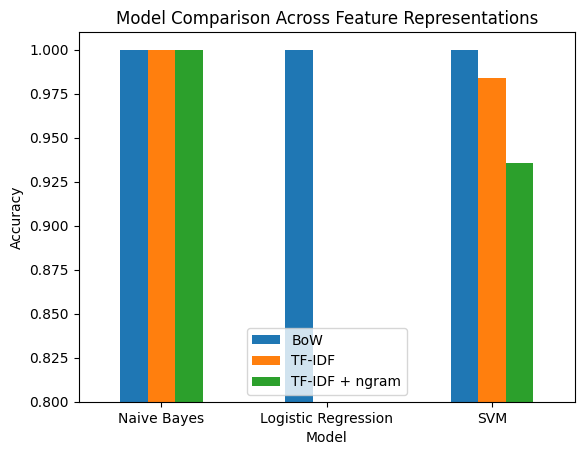

In [ ]:
#Plot Comparison Graph (For Report)


import matplotlib.pyplot as plt

results.set_index("Model").plot(kind="bar")

plt.ylabel("Accuracy")
plt.title("Model Comparison Across Feature Representations")
plt.ylim(0.8, 1.01)
plt.xticks(rotation=0)
plt.show()

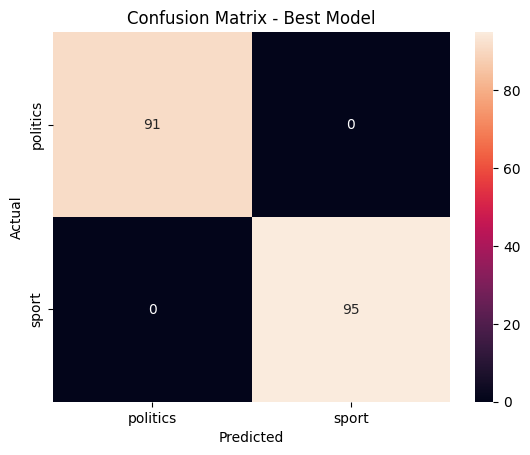

In [ ]:
#Confusion Matrix for Best Model

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_svm, y_pred_svm)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["politics", "sport"],
            yticklabels=["politics", "sport"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Model")
plt.show()

In [ ]:
import time

start = time.time()
nb_model.fit(X_train, y_train)
print("NB Training Time:", time.time() - start)


NB Training Time: 0.05188918113708496
